In [2]:
require(data.table)
require(tidyverse)

## 1. Read data 

In [4]:
dat.mat <- fread('../dat/1901/beta.promoter.long_matrix.txt')
dat.mat$overlap <- NULL 
#dat.mat$cell <- NULL #no need cell id 


In [5]:
head(dat.mat)

peak,gene,cluster,cell
1:859052-860562,SAMD11,beta_1,Islet1-fresh_AGACACCTACTCGCTATCGACTAGATAGA
1:859052-860562,SAMD11,beta_2,Islet1-fresh_AGACACCTACTCGCTATTCTAGCTGGTTG
1:859052-860562,SAMD11,beta_1,Islet1-fresh_AGACACCTAGGCAGAATCTCTCCGAGGCG
1:859052-860562,SAMD11,beta_1,Islet1-fresh_AGACACCTCGTACTAGAAGGAGTACAGGA
1:859052-860562,SAMD11,beta_1,Islet1-fresh_AGACACCTCTCTCTACACTGCATAAGGCG
1:859052-860562,SAMD11,beta_2,Islet1-fresh_AGACACCTCTCTCTACTATCCTCTTATAG


 Concepts: 
1. `promoter region`: -500bp + 500bp for all TSS in gencode 
2. `promoter Peaks`: peaks that overlap promoter region

In [6]:
dat.summary <- list() 
dat.summary$n.unique.gene <- length(unique(dat.mat$gene))
dat.summary$n.promoter.peak <- length(unique(dat.mat$peak))

In [7]:
# get all cells 
dat.all.cells <- fread('../dat/output.umap.ab.filtered.csv')
dat.all.cells <- table(dat.all.cells$cluster) # table for all cells

## 2. Fisher's exact test at Gene level 

As long as there is any promoter peaks in that cell, the gene's promoter is open. 

1. get total alpha 1 and alpha 2 cells 
2. test hit in alpha1 vs hit in alpha2  (create contentigen table)
3. perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) or [chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test)

### 2.1 Prepare data

In [11]:
# prepare data
dat.mat.gene_level <- dat.mat%>%
    select(-peak)%>%
    distinct()
head(dat.mat.gene_level)

gene,cluster,cell
SAMD11,beta_1,Islet1-fresh_AGACACCTACTCGCTATCGACTAGATAGA
SAMD11,beta_2,Islet1-fresh_AGACACCTACTCGCTATTCTAGCTGGTTG
SAMD11,beta_1,Islet1-fresh_AGACACCTAGGCAGAATCTCTCCGAGGCG
SAMD11,beta_1,Islet1-fresh_AGACACCTCGTACTAGAAGGAGTACAGGA
SAMD11,beta_1,Islet1-fresh_AGACACCTCTCTCTACACTGCATAAGGCG
SAMD11,beta_2,Islet1-fresh_AGACACCTCTCTCTACTATCCTCTTATAG


In [12]:
cat("Check how rows changed:\n") 
cat(sprintf("Before applying uniquness, # of rows:%d\n",nrow(dat.mat)))
cat(sprintf("After applying uniquness, # of rows:%d\n",nrow(dat.mat.gene_level)))


Check how rows changed:
Before applying uniquness, # of rows:10962395
After applying uniquness, # of rows:10667716


### 2.2 check if there are duplicated cell for same gene

In [30]:
test.dat <-dat.mat.gene_level%>% filter (gene==all.genes[2]) 
head(test.dat) 

gene,cluster,cell
NOC2L,beta_1,Islet1-fresh_AGACACCTACTCGCTAAAGGAGTAATAGA
NOC2L,beta_1,Islet1-fresh_AGACACCTACTCGCTAGAGCCTTATATAG
NOC2L,beta_1,Islet1-fresh_AGACACCTACTGAGCGAAGGCTATGGCTC
NOC2L,beta_1,Islet1-fresh_AGACACCTACTGAGCGTTCTAGCTATAGA
NOC2L,beta_1,Islet1-fresh_AGACACCTAGGCAGAATCTCTCCGAGGCG
NOC2L,beta_2,Islet1-fresh_AGACACCTATCTCAGGGTAAGGAGGGCTC


In [14]:
# check if there are duplicated cells for the same gene SMAD11 
cat(sprintf("check if there are duplicated cells for the same gene SMAD11:%i",
            !length(unique(test.dat$cell))== nrow(test.dat)))

check if there are duplicated cells for the same gene SMAD11:0

In [15]:
# so remove cell column
#dat.mat.gene_level <- dat.mat.gene_level %>% select(-cell)
sum(is.na(dat.mat.gene_level))

[1] 0

### 2.3 perform fisher's exact test for all genes

In [33]:
dat.mat.gene_level<- dat.mat.gene_level %>% select(-cell)
all.genes <- unique(dat.mat.gene_level$gene)
cat(sprintf("There are %d unique genes.",length(all.genes)))

There are 15282 unique genes.

In [60]:
fun.ftestPerGene <- function(g="SAMD11"){
    test.dat <-  table(dat.mat.gene_level%>% filter (gene==g)) # table for test dat
    table.res <- as.vector(test.dat)
    names(table.res) <- colnames(test.dat)
    # handle if 0 for one subtype 
    a=setdiff(c("beta_1","beta_2"),    names(table.res))
    table.res[a]<-0
    
    test.tab <- matrix(c(table.res["beta_1"], table.res["beta_2"], 
                         dat.all.cells['beta_1']-table.res["beta_1"], 
                         dat.all.cells['beta_2']-table.res["beta_2"]),
                       byrow =  T,       
                       nrow = 2,
                       dimnames = list(expressed = c("Yes", "No"),
                       subtype = c("b1", "b2")))
    test.res <- fisher.test(test.tab)
    res <- list(pval=test.res$p.value/2,
                odds=test.res$estimate,
                type1_frac=test.tab[1]/(test.tab[1]+test.tab[2]),
                type2_frac=test.tab[3]/(test.tab[3]+test.tab[4])
               )
    res
}

fun.ftestPerGene()



$pval
[1] 5.791039e-09

$odds
odds ratio 
  1.416723 

$type1_frac
[1] 0.2289848

$type2_frac
[1] 0.1732955

In [61]:
# time consumming task
if(T){require(parallel)
system.time(res.genes_level.b <- mclapply(all.genes,function(x) fun.ftestPerGene(g = x),mc.cores = 8))}

    user   system  elapsed 
1716.372   93.376  268.747 

In [62]:
res.genes_level.b.df <- do.call(rbind,res.genes_level.b)
rownames(res.genes_level.b.df) <- all.genes
head(res.genes_level.b.df)

,pval,odds,type1_frac,type2_frac
SAMD11,5.791039e-09,1.416723,0.2289848,0.1732955
NOC2L,5.391691e-06,1.447693,0.1102435,0.07883523
KLHL17,0.01986402,1.626148,0.0149288,0.009232955
PLEKHN1,0.07146685,0.7657517,0.0158475,0.02059659
C1orf170,0.4620219,1.035402,0.01653652,0.01598011
HES4,4.432709e-05,0.5211191,0.01538815,0.02911932


In [67]:
# adjust for p value 
m<- c("fdr","bonferroni","BY");names(m)<-c("FDR","padj.Bonferroni","FDR.BY")
res.genes_level.b.df <- as.data.frame(res.genes_level.b.df)
for(i in 1:3){
    res.genes_level.b.df[[names(m)[i]]] <- p.adjust(as.numeric(res.genes_level.b.df$pval),method = m[i])
}
res.genes_level.b.df$odds <- as.numeric(res.genes_level.b.df$odds)
head(res.genes_level.b.df)
fwrite(res.genes_level.b.df,"./dat/1901/res.genes_level.b.csv",row.names = T)

,pval,odds,type1_frac,type2_frac,FDR,padj.Bonferroni,FDR.BY
SAMD11,5.791039e-09,1.4167228,0.2289848,0.1732955,3.364968e-07,8.849866e-05,3.436198e-06
NOC2L,5.391691e-06,1.4476926,0.1102435,0.07883523,7.608109e-05,8.239582e-02,7.769157e-04
KLHL17,0.01986402,1.6261478,0.0149288,0.009232955,4.680986e-02,1.000000e+00,4.780073e-01
PLEKHN1,0.07146685,0.7657517,0.0158475,0.02059659,1.243914e-01,1.000000e+00,1.000000e+00
C1orf170,0.4620219,1.0354018,0.01653652,0.01598011,4.789458e-01,1.000000e+00,1.000000e+00
HES4,4.432709e-05,0.5211191,0.01538815,0.02911932,4.053899e-04,6.774066e-01,4.139712e-03


In [20]:
res.genes_level.b.df <- read.csv("../dat/1901/res.genes_level.b.csv",row.names=1)

In [21]:
head(res.genes_level.b.df)

,pval,odds,type1_frac,type2_frac,FDR,padj.Bonferroni,FDR.BY
SAMD11,5.791039e-09,1.4167228,0.22898484,0.173295455,3.364968e-07,8.849866e-05,3.436198e-06
NOC2L,5.391691e-06,1.4476926,0.11024345,0.078835227,7.608109e-05,8.239582e-02,7.769157e-04
KLHL17,1.986402e-02,1.6261478,0.01492880,0.009232955,4.680986e-02,1.000000e+00,4.780073e-01
PLEKHN1,7.146685e-02,0.7657517,0.01584750,0.020596591,1.243914e-01,1.000000e+00,1.000000e+00
C1orf170,4.620219e-01,1.0354018,0.01653652,0.015980114,4.789458e-01,1.000000e+00,1.000000e+00
HES4,4.432709e-05,0.5211191,0.01538815,0.029119318,4.053899e-04,6.774066e-01,4.139712e-03


### 2.4 Plot and explore the results 

In [22]:
range(log10(res.genes_level.b.df$padj.Bonferroni))
#sum(is.infinite(as.numeric(res.genes_level.a.df$odds)))
range((res.genes_level.b.df%>% gather(key="subtype",value = "frac",3:4))$frac)

[1] -41.32642   0.00000

[1] 0.0000000 0.5788352

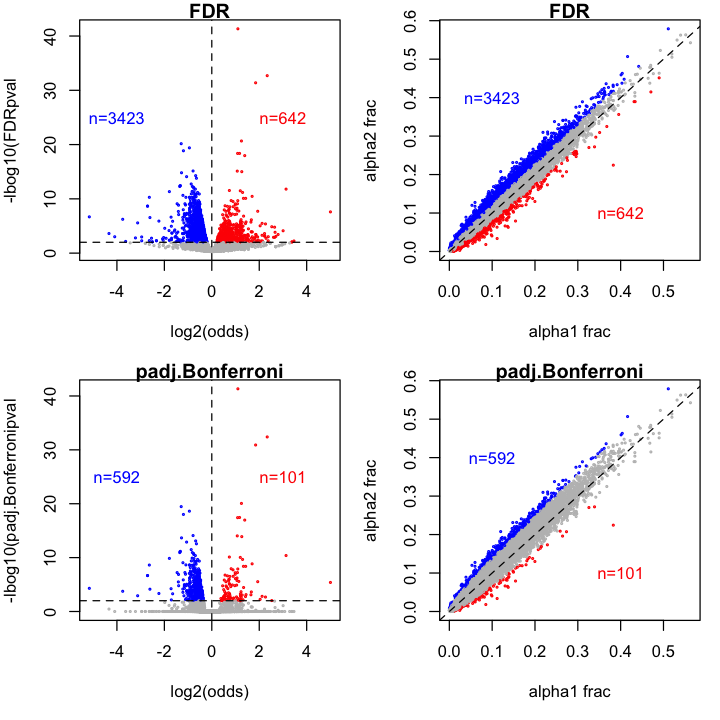

In [26]:
require(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)
require(LSD)
par(mar=c(5,4,1,1),mfrow = c(2,2))
for(m in c("FDR","padj.Bonferroni")){
    up<- res.genes_level.b.df[,m] <0.01 & log2(res.genes_level.b.df$odds)>0
    down<-res.genes_level.b.df[,m] <0.01 & log2(res.genes_level.b.df$odds)< 0
plot(x=log2(res.genes_level.b.df$odds),y=-log10(as.numeric(res.genes_level.b.df[,m])),
     xlab = "log2(odds)",ylab=paste0('-lbog10(',m,'pval'),cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(h = 2,col=1,lty=2)
abline(v=0,col=1,lty=2)
text(-4,25,col='blue',labels = paste0("n=",sum(down)))
text(3,25,col='red',labels = paste0("n=",sum(up)))

# scatter 
plot(x=as.numeric(res.genes_level.b.df$type1_frac),y=as.numeric(res.genes_level.b.df$type2_frac),
     xlab = "alpha1 frac",ylab='alpha2 frac',cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(a=0,b = 1,col=1,lty=2)
text(.1,.4,col='blue',labels = paste0("n=",sum(down)))
text(.4,.1,col='red',labels = paste0("n=",sum(up)))
}



# MAplot
if(F){
    plot(y=log2(res.genes_level.b.df$odds),x=as.numeric(res.genes_level.b.df$type1_frac),
            ylab = "log2(odds)",xlab='apha1 frac',cex=.25,col='grey',pch=16,
            main = '')

    abline(h = c(-1,1),col=2,lty=2)

}


#ggplot(res.genes_level.b.df,aes(odds,-log10(FDR)))+geom_point()

#### 2.4.0 use padj only

In [96]:
pd<- res.genes_level.b.df%>% gather(key="subtype",value = "frac",3:4)
sum(res.genes_level.b.df$padj.Bonferroni <0.01 & abs(log2(res.genes_level.b.df$odds))>1)
sum(res.genes_level.b.df$FDR <0.01 & abs(log2(res.genes_level.b.df$odds))>1)
length(res.genes_level.b.df$pval)

[1] 90

[1] 299

[1] 15282

In [71]:
head(pd)

pval,odds,FDR,padj.Bonferroni,FDR.BY,subtype,frac
5.791039e-09,1.4167228,3.364968e-07,8.849866e-05,3.436198e-06,type1_frac,0.2289848
5.391691e-06,1.4476926,7.608109e-05,8.239582e-02,7.769157e-04,type1_frac,0.1102435
0.01986402,1.6261478,4.680986e-02,1.000000e+00,4.780073e-01,type1_frac,0.0149288
0.07146685,0.7657517,1.243914e-01,1.000000e+00,1.000000e+00,type1_frac,0.0158475
0.4620219,1.0354018,4.789458e-01,1.000000e+00,1.000000e+00,type1_frac,0.01653652
4.432709e-05,0.5211191,4.053899e-04,6.774066e-01,4.139712e-03,type1_frac,0.01538815


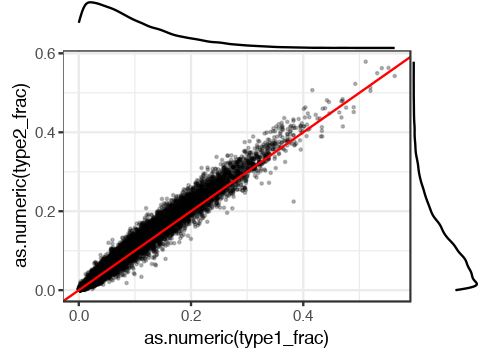

In [72]:
options(repr.plot.width=4, repr.plot.height=3)
require(ggExtra)
p <- ggplot(res.genes_level.b.df, aes(as.numeric(type1_frac),
                                      as.numeric(type2_frac))) +
    geom_point(alpha=.25,size=.25) + theme_bw()+
    geom_abline(slope = 1,intercept = 0,color='red')
# add marginal histograms
ggExtra::ggMarginal(p, type = "density")

#### 2.4.2 Volcano plot

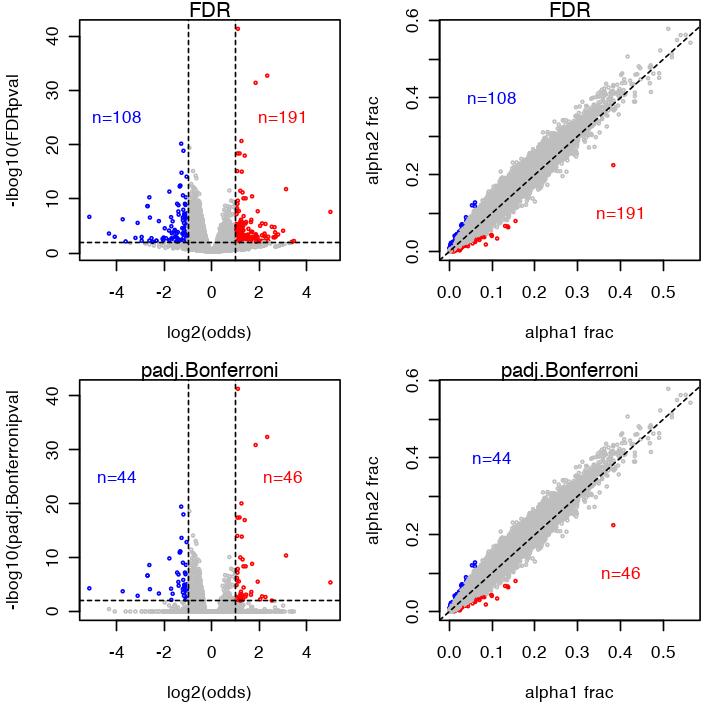

In [126]:
require(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)
require(LSD)
par(mar=c(5,4,1,1),mfrow = c(2,2))
for(m in c("FDR","padj.Bonferroni")){
    up<- res.genes_level.b.df[,m] <0.01 & log2(res.genes_level.b.df$odds)>1
    down<-res.genes_level.b.df[,m] <0.01 & log2(res.genes_level.b.df$odds)< -1
plot(x=log2(res.genes_level.b.df$odds),y=-log10(as.numeric(res.genes_level.b.df[,m])),
     xlab = "log2(odds)",ylab=paste0('-lbog10(',m,'pval'),cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(h = 2,col=1,lty=2)
abline(v=c(-1,1),col=1,lty=2)
text(-4,25,col='blue',labels = paste0("n=",sum(down)))
text(3,25,col='red',labels = paste0("n=",sum(up)))

# scatter 
plot(x=as.numeric(res.genes_level.b.df$type1_frac),y=as.numeric(res.genes_level.b.df$type2_frac),
     xlab = "alpha1 frac",ylab='alpha2 frac',cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(a=0,b = 1,col=1,lty=2)
text(.1,.4,col='blue',labels = paste0("n=",sum(down)))
text(.4,.1,col='red',labels = paste0("n=",sum(up)))
}



# MAplot
if(F){
    plot(y=log2(res.genes_level.b.df$odds),x=as.numeric(res.genes_level.b.df$type1_frac),
            ylab = "log2(odds)",xlab='apha1 frac',cex=.25,col='grey',pch=16,
            main = '')

    abline(h = c(-1,1),col=2,lty=2)

}


#ggplot(res.genes_level.b.df,aes(odds,-log10(FDR)))+geom_point()

### 2.5 GOterm analysis (padj.bonferroni)

In [108]:
beta.glist <- list()
beta.glist$beta1<- rownames(res.genes_level.b.df)[up]
beta.glist$beta2<- rownames(res.genes_level.b.df)[down]
beta.glist

$beta1
 [1] "TP73"         "RHBDL2"       "TMCO2"        "GBP5"         "PKP1"        
 [6] "OR13A1"       "CHST3"        "PDE6C"        "INS-IGF2"     "INS"         
[11] "MMP26"        "ABCC8"        "MS4A8"        "ZP1"          "KITLG"       
[16] "DHRS2"        "SMAD6"        "BTBD17"       "MYOM1"        "GREB1L"      
[21] "CDH20"        "NWD1"         "DYSF"         "XIRP2"        "G6PC2"       
[26] "FERMT1"       "ID1"          "NPEPL1"       "CCR8"         "RP11-723O4.6"
[31] "FREM3"        "DCHS2"        "KLKB1"        "TENM2"        "PI16"        
[36] "KCNK17"       "HTR1B"        "FUT9"         "HS3ST5"       "FAM162B"     
[41] "IGF2BP3"      "DDC"          "DGKI"         "HR"           "RNF183"      
[46] "STARD8"      

$beta2
 [1] "SH2D5"          "GPATCH3"        "SESN2"          "PLEKHO1"       
 [5] "KMO"            "VIM"            "BEST1"          "FOSL1"         
 [9] "C11orf80"       "MMP10"          "NDUFA4L2"       "GATC"          
[13] "TRIAP1"         "GPR183"         "TMEM95"         "ALOXE3"        
[17] "RP11-385D13.1"  "NT5M"           "KRTAP4-6"       "PTGES3L-AARSD1"
[21] "PTGES3L"        "RUNDC1"         "PLEKHM1"        "NSF"           
[25] "CHERP"          "ARMC6"          "PPP1R15A"       "AC016722.2"    
[29] "AC092675.3"     "ACMSD"          "MYO3B"          "BPIFC"         
[33] "CP"             "UGT2B7"         "SLC7A11"        "IL31RA"        
[37] "RAET1G"         "RAET1L"         "ACHE"           "CPA5"          
[41] "C8orf86"        "C9orf131"       "FLJ00273"       "OGN"

In [124]:
require(enrichR)
dbs<- c("GO_Biological_Process_2018","KEGG_2018")
go.res.b <- list()
enriched <- enrichr(beta.glist$beta1, dbs)
go.res.b$beta1 <- enriched
enriched[["GO_Biological_Process_2018"]]%>%
    arrange(Adjusted.P.value)%>%
    select(-starts_with("old"))%>%
    filter(Adjusted.P.value<0.1)

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2018... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
positive regulation of insulin receptor signaling pathway (GO:0046628),2/8,0.0001436371,0.03210288,-1.975236,17.477329,INS-IGF2;INS
regulation of protein secretion (GO:0050708),4/108,0.0001101922,0.03210288,-1.270394,11.577458,MYOM1;G6PC2;ABCC8;INS
positive regulation of cellular response to insulin stimulus (GO:1900078),2/16,0.0006084107,0.05101207,-2.289520,16.953116,INS-IGF2;INS
regulation of peptide hormone secretion (GO:0090276),3/74,0.0006583933,0.05101207,-1.838383,13.467459,G6PC2;ABCC8;INS
carbohydrate homeostasis (GO:0033500),3/64,0.0004300197,0.05101207,-1.404402,10.886478,G6PC2;INS-IGF2;INS
glucose homeostasis (GO:0042593),3/75,0.0006847258,0.05101207,-1.248809,9.099434,G6PC2;INS-IGF2;INS
response to nutrient levels (GO:0031667),2/19,0.0008631841,0.05512047,-2.221915,15.675352,INS-IGF2;INS
positive regulation of DNA replication (GO:0045740),2/36,0.0031020612,0.09898661,-2.167333,12.517842,KITLG;INS
response to hexose (GO:0009746),2/28,0.0018831261,0.09898661,-1.903257,11.942598,INS-IGF2;INS
negative regulation of secretion by cell (GO:1903531),2/31,0.0023064055,0.09898661,-1.885175,11.446904,HTR1B;INS


In [119]:
enriched[["GO_Biological_Process_2018"]]%>%
    arrange(Adjusted.P.value)%>%
    select(-starts_with("old"))%>%
    filter(Adjusted.P.value<0.1)

Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
tryptophan metabolic process (GO:0006568),2/11,0.0002569047,0.02851642,-2.628382,21.72832,KMO;ACMSD
indolalkylamine catabolic process (GO:0046218),2/10,0.0002104892,0.02851642,-2.565043,21.71585,KMO;ACMSD
tryptophan catabolic process (GO:0006569),2/11,0.0002569047,0.02851642,-2.527580,20.89501,KMO;ACMSD
aromatic amino acid family catabolic process (GO:0009074),2/21,0.0009672863,0.08052659,-1.965112,13.63987,KMO;ACMSD
signal transduction in response to DNA damage (GO:0042770),2/26,0.0014865704,0.09900559,-2.050741,13.35296,SESN2;TRIAP1


### 2.6 Go term using FDR

In [127]:
m<-'FDR'
up<- res.genes_level.b.df[,m] <0.01 & log2(res.genes_level.b.df$odds)>1
    down<-res.genes_level.b.df[,m] <0.01 & log2(res.genes_level.b.df$odds)< -1

go.res.b <- list()
#beta1
enriched <- enrichr(rownames(res.genes_level.b.df)[up], dbs)
enriched[["GO_Biological_Process_2018"]]%>%
    arrange(Adjusted.P.value)%>%
    select(-starts_with("old"))%>%
    filter(Adjusted.P.value<0.1)

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2018... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes


In [130]:
#beta 2
sum(down)
enriched <- enrichr(rownames(res.genes_level.b.df)[down], dbs)
enriched[["GO_Biological_Process_2018"]]%>%
    arrange(Adjusted.P.value)%>%
    select(-starts_with("old"))%>%
    filter(Adjusted.P.value<0.1)

[1] 108

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2018... Done.
Parsing results... Done.


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
lipid transport (GO:0006869),5/92,0.0001416482,0.09660409,-1.776177,15.74077,ABCA10;CAV3;AKR1C1;SLCO1B3;TRIAP1


In [116]:
save(file = './dat/1901/res.genes.b.all.rdata',list = c("go.res.b","beta.glist"))